# Ultra functionalized code with non-linearity (add more layers to model)
Completely using fast.ai/pytorch libraries and python classes.

In [1]:
from fastai.vision.all import *

/home/gg/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Preparing dataset

In [2]:
full_dataset_dir = untar_data(URLs.MNIST)

In [3]:
image_size=28*28 # np.prod(array(Image.open(Path.ls(full_dataset_dir/'training/3/')[0])).shape)

In [4]:
numbers= [3,7] #range(0,10)

In [5]:
def load_mnist(top_dir='testing'):
    full_dataset=[]
    labels=[]
    for number in numbers:
        path = Path.ls(full_dataset_dir/'{}/{}/'.format(top_dir,number))
        im_tensor = [ tensor(Image.open(p)) for p in path ]
        for i in range(0,len(im_tensor)): # otherwise it would simply be a list of lists
            full_dataset.append(im_tensor[i])
            labels.append(number)
    x_stack = (torch.stack(full_dataset).float()/255).view(-1,image_size)
    y_stack = tensor(labels).unsqueeze(1)
    del full_dataset,labels
    return x_stack, y_stack    

In [6]:
train_x_stack,train_y_stack= load_mnist('training')
test_x_stack,test_y_stack= load_mnist('testing')

In [7]:
train_x_stack.shape, train_y_stack.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [8]:
test_y_stack.shape, test_y_stack.shape

(torch.Size([2038, 1]), torch.Size([2038, 1]))

Assign 1 for 3s and 0 for 7s.

In [9]:
train_y_stack = (train_y_stack == 3) * 1

In [10]:
test_y_stack = (test_y_stack == 3) * 1

In [11]:
train_dset = list(zip(train_x_stack,train_y_stack))
test_dset = list(zip(test_x_stack,test_y_stack))
dl = DataLoader(train_dset,batch_size=256) # train in batches for each epoch
test_dl = DataLoader(test_dset,batch_size=256) # train in batches for each epoch
dls = DataLoaders(dl,test_dl)

# Define Loss function

In [12]:
def sigmoid(x) : return 1/(1+torch.exp(-x))

def mnist_loss(predictions,targets):
    predictions=sigmoid(predictions)
    return torch.where(targets==1,1-predictions,predictions).mean()

# Define non-Linear model using pytorch with 30 activations

This model is a simple function that does this:
```
def simple_net(x):
    res = x@w1 + b1 #linear layer
    res = res.max(tensor(0.0)) #ReLU , non-linearity, makes -ve values 0
    res = res@w2 + b2 #linear layer
    return res
```

In [13]:
init_params = lambda size,std=1: (torch.randn(size)*std).requires_grad_()

In [14]:
w1=init_params((image_size,30)) # 30 activations
b1 = init_params(30)
w2=init_params((30,1))
b2 = init_params(1)

The above simple_net function can be replaced with the following using pytorch.

**Initializing weights for each layer** and eveything else will be done by pytorch.

In [15]:
simple_net = nn.Sequential(
                nn.Linear(image_size,30),
                nn.ReLU(),
                nn.Linear(30,1))

Can make different combinations and layers. Just make sure the next layer has correct number of activations.

In [16]:
list(simple_net.parameters())

[Parameter containing:
 tensor([[-0.0022,  0.0172,  0.0110,  ..., -0.0274, -0.0043,  0.0326],
         [-0.0222,  0.0355, -0.0131,  ...,  0.0121, -0.0285,  0.0207],
         [ 0.0227,  0.0180,  0.0113,  ..., -0.0192,  0.0264,  0.0138],
         ...,
         [-0.0026,  0.0090,  0.0217,  ...,  0.0195,  0.0160, -0.0162],
         [-0.0150,  0.0214,  0.0189,  ..., -0.0144, -0.0099, -0.0048],
         [-0.0012,  0.0024, -0.0352,  ...,  0.0066,  0.0271, -0.0030]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0238, -0.0003, -0.0157, -0.0201, -0.0076,  0.0048, -0.0318,  0.0078,
          0.0016, -0.0182,  0.0255, -0.0187, -0.0103,  0.0095, -0.0304,  0.0035,
         -0.0356,  0.0157, -0.0155, -0.0274,  0.0206,  0.0336, -0.0224, -0.0313,
         -0.0307, -0.0335,  0.0334,  0.0242,  0.0023,  0.0152],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0546,  0.0854,  0.1526,  0.1221,  0.0375, -0.1124,  0.0157, -0.0411,
          -0.1747, -0.0922,  0.0023,  0.112

# Validation loop

In [17]:
# check for each batch if 3 or 7 and check it with the label
def batch_accuracy(x,y):
    preds=x.sigmoid()
    correct = (preds>0.5) == y
    return correct.float().mean()

# Fastai method to do the training bit using `dls`

**SGD manages the grad part. Learner manages the training part and checking with test set**

In [18]:
learn = Learner(dls, model=simple_net, opt_func=SGD, lr = 0.1, loss_func = mnist_loss, metrics= batch_accuracy)

In [19]:
learn.fit(40)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.300312,0.415098,0.504416,00:00
1,0.142049,0.215728,0.820412,00:00
2,0.079370,0.107921,0.921982,00:00
3,0.052917,0.073876,0.945044,00:00
4,0.040604,0.058368,0.959274,00:00
5,0.034200,0.049603,0.964671,00:00
6,0.030457,0.044059,0.966143,00:00
7,0.027999,0.040280,0.967615,00:00
8,0.026216,0.037544,0.968597,00:00
9,0.024824,0.035462,0.969087,00:00


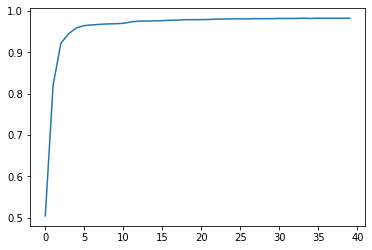

In [20]:
plt.plot(L(learn.recorder.values).itemgot(2))